[INFO] Reference encoding loaded.
[INFO] Loaded weights from meso4.h5
[INFO] Starting detection. Press 'Q' to quit.


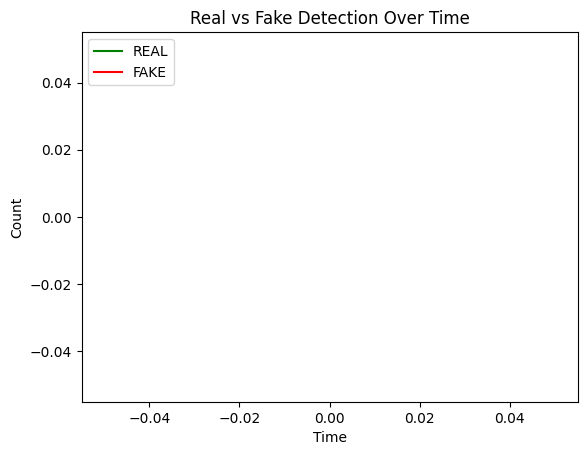

[INFO] Faces detected: 1
[DEBUG] Distance from reference: 0.754
[INFO] Face doesn't match reference.
[INFO] FPS: 0.13
[INFO] Faces detected: 1
[DEBUG] Distance from reference: 0.755
[INFO] Face doesn't match reference.
[INFO] FPS: 0.35
[INFO] Faces detected: 0
[INFO] FPS: 0.38
[INFO] Faces detected: 0
[INFO] FPS: 0.36
[INFO] Faces detected: 0
[INFO] FPS: 0.37
[INFO] Faces detected: 1
[DEBUG] Distance from reference: 0.754
[INFO] Face doesn't match reference.
[INFO] FPS: 0.30
[INFO] Faces detected: 1
[DEBUG] Distance from reference: 0.754
[INFO] Face doesn't match reference.
[INFO] FPS: 0.25
[INFO] Faces detected: 1
[DEBUG] Distance from reference: 0.754
[INFO] Face doesn't match reference.
[INFO] FPS: 0.28
[INFO] Faces detected: 1
[DEBUG] Distance from reference: 0.754
[INFO] Face doesn't match reference.
[INFO] FPS: 0.25
[INFO] Faces detected: 1
[DEBUG] Distance from reference: 0.754
[INFO] Face doesn't match reference.
[INFO] FPS: 0.27
[INFO] Faces detected: 1
[DEBUG] Distance from r

In [5]:
from live_graph import RealTimeGraph  # 👈 Import your module

import cv2
import numpy as np
import face_recognition
import mss
import time
import os
from keras.models import load_model

# ========== Load Deepfake Detection Model ==========
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense

class MesoNet:
    def __init__(self, model_path='meso4.h5'):
        try:
            self.model = self._build_model()
            self.model.load_weights(model_path)
            print(f"[INFO] Loaded weights from {model_path}")
        except Exception as e:
            print(f"[ERROR] Could not load weights: {e}")
            raise e

    def _build_model(self):
        x = Input(shape=(256, 256, 3))
        y = Conv2D(8, (3, 3), padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = MaxPooling2D(pool_size=(2, 2), padding='same')(y)

        y = Conv2D(8, (5, 5), padding='same')(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = MaxPooling2D(pool_size=(2, 2), padding='same')(y)

        y = Conv2D(16, (5, 5), padding='same')(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = MaxPooling2D(pool_size=(2, 2), padding='same')(y)

        y = Conv2D(16, (5, 5), padding='same')(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = MaxPooling2D(pool_size=(4, 4), padding='same')(y)

        y = Flatten()(y)
        y = Dense(units=16)(y)
        y = Activation('relu')(y)
        y = Dense(units=1, activation='sigmoid')(y)

        return Model(inputs=x, outputs=y)

    def predict(self, face_img):
        try:
            img = cv2.resize(face_img, (256, 256))
            batch = np.expand_dims(img.astype('float32') / 255., axis=0)
            prob = self.model.predict(batch)[0][0]
            return prob
        except Exception as e:
            print(f"[ERROR] Prediction failed: {e}")
            return 0.0

# ========== Main Function ==========
def run_deepfake_with_detection(reference_image_path='gujju.jpg',
                                 model_path='meso4.h5',
                                 output_folder='deepfake_outputs'):
    # Load reference image
    ref = face_recognition.load_image_file(reference_image_path)
    ref_encodings = face_recognition.face_encodings(ref)
    if len(ref_encodings) == 0:
        raise ValueError(f"No face found in reference image: {reference_image_path}")
    ref_enc = ref_encodings[0]
    print(f"[INFO] Reference encoding loaded.")

    # Setup
    os.makedirs(output_folder, exist_ok=True)
    sct = mss.mss()
    monitor = sct.monitors[1]
    meso = MesoNet(model_path)
    graph = RealTimeGraph()         # 👈 Create graph object
    graph.start()                   # 👈 Start the live plot
    frame_id = int(time.time())

    print("[INFO] Starting detection. Press 'Q' to quit.")

    try:
        while True:
            start_time = time.time()
            scr = np.array(sct.grab(monitor))
            rgb = cv2.cvtColor(scr, cv2.COLOR_BGRA2RGB)

            # Face detection
            face_locations = face_recognition.face_locations(rgb)
            face_encodings = face_recognition.face_encodings(rgb, face_locations)
            print(f"[INFO] Faces detected: {len(face_locations)}")

            for (top, right, bottom, left), enc in zip(face_locations, face_encodings):
                distance = face_recognition.face_distance([ref_enc], enc)[0]
                print(f"[DEBUG] Distance from reference: {distance:.3f}")
                match = face_recognition.compare_faces([ref_enc], enc, tolerance=0.6)[0]

                if match:
                    face_img = rgb[top:bottom, left:right]
                    prob = meso.predict(face_img)
                    label = "REAL" if prob > 0.5 else "FAKE"
                    color = (0, 255, 0) if label == "REAL" else (0, 0, 255)
                    prob_pct = prob * 100

                    # ===== UPDATE LIVE GRAPH =====
                    graph.update(label)

                    # ===== Terminal Output =====
                    print(f"[RESULT] Detected face is {label} with probability: {prob_pct:.2f}%")

                    # ===== Overlay on Image =====
                    cv2.rectangle(rgb, (left, top), (right, bottom), color, 2)
                    cv2.putText(rgb, f"{label} {prob_pct:.1f}%", (left, top - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
                    cv2.putText(rgb, f"DEEPFAKE STATUS: {label} ({prob_pct:.1f}%)", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)

                    # ===== Save Frame =====
                    fname = os.path.join(output_folder, f"{label}_{int(prob_pct)}_{frame_id}.jpg")
                    cv2.imwrite(fname, cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
                    print(f"[✔] Saved: {fname}")
                    frame_id += 1

                else:
                    print("[INFO] Face doesn't match reference.")

            cv2.imshow("Deepfake Detection", cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
            if cv2.waitKey(1) & 0xFF == ord('q'):
                print("[INFO] Exiting...")
                break

            print(f"[INFO] FPS: {1 / (time.time() - start_time):.2f}")

    except Exception as e:
        print("[ERROR]", e)
    finally:
        graph.stop()                 # 👈 Stop the graph thread
        cv2.destroyAllWindows()



# ========== Run the Program ==========
# Make sure meso4.h5 and gujju.jpg are in the same folder
# Uncomment to run directly:
run_deepfake_with_detection()


✅ Model architecture defined and weights loaded.
